<a href="https://colab.research.google.com/github/ankesh86/BlueBikes_MachineLearning/blob/main/BlueBikesData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [208]:
URLA = 'https://s3.amazonaws.com/hubway-data/202404-bluebikes-tripdata.zip'
URLB = 'https://s3.amazonaws.com/hubway-data/202405-bluebikes-tripdata.zip'

raw_data = pd.read_csv('202405-bluebikes-tripdata.csv', encoding='utf-8')
raw_data.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,2223D2584B189BDA,classic_bike,2024-05-29 13:40:33,2024-05-29 13:59:41,Bowdoin St at Quincy St,B32031,Christian Science Plaza - Massachusetts Ave at...,B32005,42.307852,-71.065122,42.343666,-71.085824,member
1,96EA32F96F1EDB68,classic_bike,2024-05-09 18:28:25,2024-05-09 18:36:00,Mugar Way at Beacon St,D32017,Blossom St at Charles St,D32050,42.355536,-71.072869,42.364356,-71.069594,member
2,FA3D2E0C93FC6106,classic_bike,2024-05-02 14:57:16,2024-05-02 15:07:48,Brookline Village - Station Street at MBTA,K32003,Landmark Center - Brookline Ave at Park Dr,B32015,42.332744,-71.116267,42.343691,-71.102353,casual
3,1B06C3F3908BFF50,classic_bike,2024-05-02 17:28:58,2024-05-02 17:44:19,Mugar Way at Beacon St,D32017,Landmark Center - Brookline Ave at Park Dr,B32015,42.355536,-71.072869,42.343691,-71.102353,casual
4,EDBDA5B466F9CE2E,classic_bike,2024-05-15 17:37:02,2024-05-15 17:45:09,Brookline Village - Station Street at MBTA,K32003,Marion St at Harvard St,K32012,42.332744,-71.116267,42.340122,-71.120706,member


In [209]:
print(raw_data.info())
print(raw_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440534 entries, 0 to 440533
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ride_id             440534 non-null  object 
 1   rideable_type       440534 non-null  object 
 2   started_at          440534 non-null  object 
 3   ended_at            440534 non-null  object 
 4   start_station_name  440500 non-null  object 
 5   start_station_id    440500 non-null  object 
 6   end_station_name    439864 non-null  object 
 7   end_station_id      439864 non-null  object 
 8   start_lat           440534 non-null  float64
 9   start_lng           440534 non-null  float64
 10  end_lat             440194 non-null  float64
 11  end_lng             440194 non-null  float64
 12  member_casual       440534 non-null  object 
dtypes: float64(4), object(9)
memory usage: 43.7+ MB
None
ride_id                 0
rideable_type           0
started_at              0
end

In [210]:
#preprocessing

raw_data_cleaned = raw_data.dropna()
# Assuming raw_data_cleaned is a slice from another DataFrame
raw_data_cleaned = raw_data_cleaned.copy()
raw_data_cleaned['started_at'] = raw_data_cleaned['started_at'].astype('datetime64[ns]')
raw_data_cleaned['ended_at'] = raw_data_cleaned['ended_at'].astype('datetime64[ns]')



raw_data_cleaned['ride_duration'] = raw_data_cleaned['ended_at'] - raw_data_cleaned['started_at']

raw_data_cleaned['ride_duration_hours'] = raw_data_cleaned['ride_duration'].dt.total_seconds() / 3600
raw_data_cleaned['ride_duration_minutes'] = raw_data_cleaned['ride_duration'].dt.total_seconds() / 60
raw_data_cleaned['ride_duration_seconds'] = raw_data_cleaned['ride_duration'].dt.total_seconds()

#replacing negative hours data with 0
# Keep only rows where the ride duration is non-negative
raw_data_cleaned = raw_data_cleaned[raw_data_cleaned['ride_duration_hours'] >= 0]

print(raw_data_cleaned.head(5))

            ride_id rideable_type          started_at            ended_at  \
0  2223D2584B189BDA  classic_bike 2024-05-29 13:40:33 2024-05-29 13:59:41   
1  96EA32F96F1EDB68  classic_bike 2024-05-09 18:28:25 2024-05-09 18:36:00   
2  FA3D2E0C93FC6106  classic_bike 2024-05-02 14:57:16 2024-05-02 15:07:48   
3  1B06C3F3908BFF50  classic_bike 2024-05-02 17:28:58 2024-05-02 17:44:19   
4  EDBDA5B466F9CE2E  classic_bike 2024-05-15 17:37:02 2024-05-15 17:45:09   

                           start_station_name start_station_id  \
0                     Bowdoin St at Quincy St           B32031   
1                      Mugar Way at Beacon St           D32017   
2  Brookline Village - Station Street at MBTA           K32003   
3                      Mugar Way at Beacon St           D32017   
4  Brookline Village - Station Street at MBTA           K32003   

                                    end_station_name end_station_id  \
0  Christian Science Plaza - Massachusetts Ave at...         B32005  

In [211]:
# Correctly setting the 'ended_at' column to datetime format using .loc
print(raw_data_cleaned.dtypes)
print(raw_data_cleaned.shape)


ride_id                           object
rideable_type                     object
started_at                datetime64[ns]
ended_at                  datetime64[ns]
start_station_name                object
start_station_id                  object
end_station_name                  object
end_station_id                    object
start_lat                        float64
start_lng                        float64
end_lat                          float64
end_lng                          float64
member_casual                     object
ride_duration            timedelta64[ns]
ride_duration_hours              float64
ride_duration_minutes            float64
ride_duration_seconds            float64
dtype: object
(439820, 17)


In [212]:
raw_data_cleaned.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_duration,ride_duration_hours,ride_duration_minutes,ride_duration_seconds
0,2223D2584B189BDA,classic_bike,2024-05-29 13:40:33,2024-05-29 13:59:41,Bowdoin St at Quincy St,B32031,Christian Science Plaza - Massachusetts Ave at...,B32005,42.307852,-71.065122,42.343666,-71.085824,member,0 days 00:19:08,0.318889,19.133333,1148.0
1,96EA32F96F1EDB68,classic_bike,2024-05-09 18:28:25,2024-05-09 18:36:00,Mugar Way at Beacon St,D32017,Blossom St at Charles St,D32050,42.355536,-71.072869,42.364356,-71.069594,member,0 days 00:07:35,0.126389,7.583333,455.0
2,FA3D2E0C93FC6106,classic_bike,2024-05-02 14:57:16,2024-05-02 15:07:48,Brookline Village - Station Street at MBTA,K32003,Landmark Center - Brookline Ave at Park Dr,B32015,42.332744,-71.116267,42.343691,-71.102353,casual,0 days 00:10:32,0.175556,10.533333,632.0
3,1B06C3F3908BFF50,classic_bike,2024-05-02 17:28:58,2024-05-02 17:44:19,Mugar Way at Beacon St,D32017,Landmark Center - Brookline Ave at Park Dr,B32015,42.355536,-71.072869,42.343691,-71.102353,casual,0 days 00:15:21,0.255833,15.350000,921.0
4,EDBDA5B466F9CE2E,classic_bike,2024-05-15 17:37:02,2024-05-15 17:45:09,Brookline Village - Station Street at MBTA,K32003,Marion St at Harvard St,K32012,42.332744,-71.116267,42.340122,-71.120706,member,0 days 00:08:07,0.135278,8.116667,487.0


In [213]:
gathered_data = raw_data_cleaned[["started_at", "rideable_type", "member_casual", "ride_duration_seconds"]]
gathered_data

,started_at,rideable_type,member_casual,ride_duration_seconds
0,2024-05-29 13:40:33,classic_bike,member,1148.0
1,2024-05-09 18:28:25,classic_bike,member,455.0
2,2024-05-02 14:57:16,classic_bike,casual,632.0
3,2024-05-02 17:28:58,classic_bike,casual,921.0
4,2024-05-15 17:37:02,classic_bike,member,487.0
...,...,...,...,...
440529,2024-05-31 19:09:41,classic_bike,casual,908.0
440530,2024-05-20 15:29:49,electric_bike,member,3414.0
440531,2024-05-31 21:52:17,classic_bike,member,1178.0
440532,2024-05-30 06:46:17,classic_bike,member,296.0


In [214]:
classical_bike_df = gathered_data[gathered_data['rideable_type'] == 'classic_bike']
electric_bike_df = gathered_data[gathered_data['rideable_type'] == 'electric_bike']

In [215]:
classical_bike_df.shape

(344875, 4)

In [216]:
import datetime

classical_bike_df = classical_bike_df.copy()
#classical_bike_df.loc[:, 'date'] = classical_bike_df['started_at'].dt.date

#classical_bike_df['started_at_parsed'] = classical_bike_df['started_at'].dt.strftime('%Y-%m-%d %H')
classical_bike_df['started_at_time'] = pd.to_datetime(classical_bike_df['started_at'].dt.strftime('%Y-%m-%d %H'))



#classical_bike_df['started_at_parsed'] = classical_bike_df['started_at'].apply(parse)

classical_bike_df.drop('started_at', axis=1, inplace=True)

In [217]:
classical_bike_df.head()

,rideable_type,member_casual,ride_duration_seconds,started_at_time
0,classic_bike,member,1148.0,2024-05-29 13:00:00
1,classic_bike,member,455.0,2024-05-09 18:00:00
2,classic_bike,casual,632.0,2024-05-02 14:00:00
3,classic_bike,casual,921.0,2024-05-02 17:00:00
4,classic_bike,member,487.0,2024-05-15 17:00:00


In [218]:
aggregated_df = classical_bike_df.pivot_table(
    index='started_at_time',
    columns='member_casual',
    values='ride_duration_seconds',
    aggfunc={
        'ride_duration_seconds': ['count', 'sum']
    }
)

# Flatten the multi-level column names and rename them
aggregated_df.columns = ['_'.join(col).strip() for col in aggregated_df.columns.values]
aggregated_df = aggregated_df.rename(columns={
    'ride_duration_seconds_count_casual': 'casual_count',
    'ride_duration_seconds_sum_casual': 'casual_duration_sum',
    'ride_duration_seconds_count_member': 'member_count',
    'ride_duration_seconds_sum_member': 'member_duration_sum'
})

# Reset index to make 'started_at_time' a column again
aggregated_df = aggregated_df.fillna(0)
aggregated_df.reset_index(inplace=True)

In [219]:
from holidays import country_holidays
us_holidays = country_holidays('US')
# For a specific subdivision (e.g. state or province):
mass_holidays = country_holidays('US', subdiv='MA')

In [220]:
aggregated_df['count'] = aggregated_df['count_casual'] + aggregated_df['count_member']
aggregated_df['travel_time'] = aggregated_df['sum_casual'] + aggregated_df['sum_member']
aggregated_df['day_of_week'] = aggregated_df['started_at_time'].dt.day_name().str.upper()
# Create a new column 'IsWeekend' by checking if the day of the week is Saturday (5) or Sunday (6)
aggregated_df['IsWeekend'] = aggregated_df['started_at_time'].dt.weekday.apply(lambda x: 1 if x in (5, 6) else 0)
# Create 'IsHoliday' column
aggregated_df['IsHoliday'] = aggregated_df['started_at_time'].dt.date.apply(lambda x: 1 if x in mass_holidays else 0)

aggregated_df.head()

,started_at_time,count_casual,count_member,sum_casual,sum_member,count,travel_time,day_of_week,IsWeekend,IsHoliday
0,2024-05-01 00:00:00,7.0,26.0,33097.0,14513.0,33.0,47610.0,WEDNESDAY,0,0
1,2024-05-01 01:00:00,7.0,11.0,3985.0,8324.0,18.0,12309.0,WEDNESDAY,0,0
2,2024-05-01 02:00:00,5.0,8.0,4001.0,4733.0,13.0,8734.0,WEDNESDAY,0,0
3,2024-05-01 03:00:00,1.0,4.0,381.0,1599.0,5.0,1980.0,WEDNESDAY,0,0
4,2024-05-01 04:00:00,1.0,6.0,853.0,4560.0,7.0,5413.0,WEDNESDAY,0,0


# **Visuals**

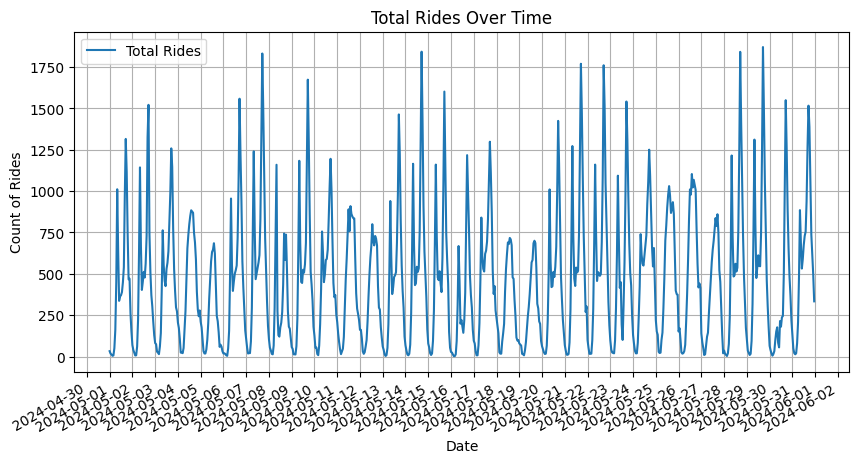

In [221]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plotting the time series data
plt.figure(figsize=(10, 5))  # Set the figure size for better readability
plt.plot(aggregated_df['started_at_time'], aggregated_df['count'], label='Total Rides')  # Add a label for the legend

# Formatting the date on the x-axis to make it more readable
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Set major ticks to be one day apart
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format the date display
plt.gcf().autofmt_xdate()  # Auto format the dates to prevent overlap

plt.title('Total Rides Over Time')  # Add a title to the plot
plt.xlabel('Date')  # Label the x-axis
plt.ylabel('Count of Rides')  # Label the y-axis
plt.legend(loc='best')  # Ensure the legend is placed in the best location
plt.grid(True)  # Add a grid for easier reading of values

plt.show()  # Display the plot

# **Seasonality Trend**

In [222]:
#seasonality
seasonality_df = aggregated_df[['started_at_time','count']]

# Check if the DataFrame has only one column and convert to Series if true
if len(seasonality_df.columns) == 1:
    data = seasonality_df.iloc[:, 0]
else:
    data = seasonality_df

# Show the first few rows of the data
print(data.head())


      started_at_time  count
0 2024-05-01 00:00:00   33.0
1 2024-05-01 01:00:00   18.0
2 2024-05-01 02:00:00   13.0
3 2024-05-01 03:00:00    5.0
4 2024-05-01 04:00:00    7.0


In [223]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Seaborn for enhanced visualizations
import calendar

# Ensure 'started_at_time' is in datetime format if not already
seasonality_df = aggregated_df[['started_at_time','count']]

seasonality_df = seasonality_df.copy()
# Extract hour and date from 'started_at_time'
seasonality_df['hour'] = seasonality_df['started_at_time'].dt.hour
seasonality_df['date'] = seasonality_df['started_at_time'].dt.date
#seasonality_df['day_of_week'] = seasonality_df['started_at_time'].dt.day_of_week

# Ensure 'date' is in datetime format if not already
seasonality_df['date'] = pd.to_datetime(seasonality_df['date'])
# Create a new column 'day_of_week' to store the name of the weekday
seasonality_df['day_of_week'] = seasonality_df['date'].dt.day_name().str.upper()

# Display the first few rows to verify
print(seasonality_df.head())


      started_at_time  count  hour       date day_of_week
0 2024-05-01 00:00:00   33.0     0 2024-05-01   WEDNESDAY
1 2024-05-01 01:00:00   18.0     1 2024-05-01   WEDNESDAY
2 2024-05-01 02:00:00   13.0     2 2024-05-01   WEDNESDAY
3 2024-05-01 03:00:00    5.0     3 2024-05-01   WEDNESDAY
4 2024-05-01 04:00:00    7.0     4 2024-05-01   WEDNESDAY


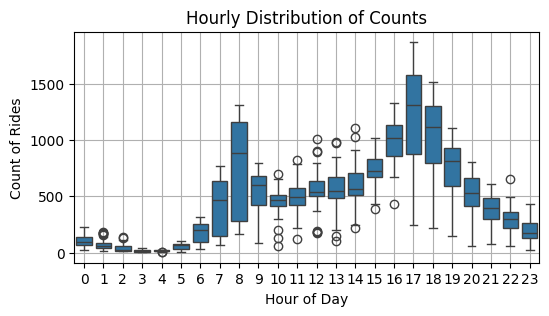

In [224]:
plt.figure(figsize=(6, 3))
sns.boxplot(x='hour', y='count', data=seasonality_df)
plt.title('Hourly Distribution of Counts')
plt.xlabel('Hour of Day')
plt.ylabel('Count of Rides')
plt.grid(True)
plt.show()

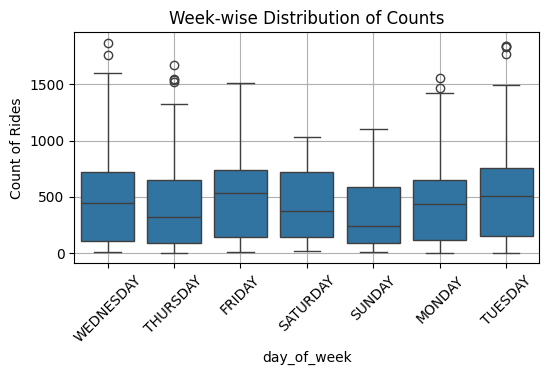

In [225]:
plt.figure(figsize=(6, 3))
sns.boxplot(x=seasonality_df['day_of_week'], y='count', data=seasonality_df)
plt.title('Week-wise Distribution of Counts')
plt.xlabel('day_of_week')
plt.ylabel('Count of Rides')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()